### Split training and test and synthesize data for training

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)  #set default figure size
import os
import sys
from PEMFC_project import _samplings , _equivalent_circuits, _reconstruct_Nyquist_plot,_data_summery 

In [25]:
eis = pd.read_csv('Data/EIS_O2_STOI.csv',header=0)
o2_stoi = pd.read_csv('Data/O2_STOI.csv',header=None)
freq = np.loadtxt('Data/PEMFC_freq.txt')
eis.drop([98,155,156,157,158, 159, 160, 161, 162, 163, 164,165,181,182,249, 250,251],inplace=True) #
eis.reset_index(inplace=True,drop=True)
o2_stoi.drop([98,155,156,157,158, 159, 160, 161, 162, 163, 164,165,181,182,249, 250,251],inplace=True)
o2_stoi.reset_index(inplace=True,drop=True)

In [26]:
eis_ny = pd.read_csv('Data/EIS_O2_STOI_ny.csv',header=0,index_col=0)
o2_stoi_ny = pd.read_csv('Data/O2_STOI_ny.csv',header=0,index_col=0)

In [28]:
X_eis = np.r_[eis, eis_ny]

y_o2_stoi = pd.concat([o2_stoi.iloc[:,0], o2_stoi_ny.iloc[:,0]],ignore_index=True)
y_c = y_o2_stoi#.replace([1.4, 1.5, 1.6, 1.8, 2.0, 2.2, 2.5, 3.0], [0,0,1, 2, 3, 4, 5, 6,])
y_c.reset_index(drop=True,inplace=True)
print(X_eis.shape)
print(y_o2_stoi.shape)
print(y_c.shape)

(296, 62)
(296,)
(296,)


In [5]:
o2_stoi_count = y_c.value_counts()
df_o2_stoi_count = pd.DataFrame(index=o2_stoi_count.index,columns=['counts','proportion'])
df_o2_stoi_count['counts'] = o2_stoi_count.values
df_o2_stoi_count['proportion'] = np.divide(o2_stoi_count.values,np.sum(o2_stoi_count.values))
df_o2_stoi_count.sort_index(inplace=True)

### Train and test split

In [6]:
from numpy.random import default_rng
from sklearn.preprocessing import MinMaxScaler
def train_test_split(df, X_eis, y_c, p_train=0.7, p_test=0.3) : 
    
    o2_stoi_counts = df['counts']
    o2_stoi_index = o2_stoi_counts.index
    y_stoi = y_c.values
    num= np.floor(o2_stoi_counts*p_train).astype(int)
    train_index = np.array([])
    rng = default_rng()
    for s,c,n in zip(o2_stoi_index, o2_stoi_counts, num) :
        print(s,c,n)
        numbers = rng.choice(c, size=n, replace=False)
        index = np.where(y_stoi==s)[0][numbers]
        train_index = np.r_[train_index,index]
    
    train_index =np.unique(train_index).astype(int)

    X_train = X_eis[train_index]
    X_test = np.delete(X_eis,train_index,0)
    
    y_c_train = y_c[train_index]
    #print(train_index)
    y_c_test = np.delete(y_c.values,train_index)
    
    return X_train, X_test,y_c_train, y_c_test

X_train, X_test, y_c_train, y_c_test = train_test_split(df_o2_stoi_count.loc[[1.4,1.5,1.6,1.8,2.0,2.2,2.5,3.0]], X_eis,y_c)

1.4 4 2
1.5 11 7
1.6 9 6
1.8 77 53
2.0 20 14
2.2 135 94
2.5 20 14
3.0 20 14


In [7]:
### Move all O2 stoi.=1.4 to test data

intent = X_train[np.where(y_c_train == 1.4)[0]]
X_test = np.r_[X_test,intent]
y_c_test = np.r_[y_c_test, [1.4,1.4]]
X_train = np.delete(X_train,np.where(y_c_train == 1.4)[0],0)
y_c_train = np.delete(y_c_train,np.where(y_c_train == 1.4)[0],0)

In [8]:
_data_summery.target_summery(pd.Series(y_c_train)).sort_index(ascending=False)

,counts,proportion
3.0,14,0.069307
2.5,14,0.069307
2.2,94,0.465347
2.0,14,0.069307
1.8,53,0.262376
1.6,6,0.029703
1.5,7,0.034653


In [9]:
_data_summery.target_summery(pd.Series(y_c_test)).sort_index(ascending=False)

,counts,proportion
3.0,6,0.063830
2.5,6,0.063830
2.2,41,0.436170
2.0,6,0.063830
1.8,24,0.255319
1.6,3,0.031915
1.5,4,0.042553
1.4,4,0.042553


In [10]:
print(X_train.shape)
print(y_c_train.shape)
print(X_test.shape)
print(y_c_test.shape)

(202, 62)
(202,)
(94, 62)
(94,)


### Naive SMOTE-ENN for training data

In [11]:
from sklearn.neighbors import NearestNeighbors

def NaiveSMOTE(X, N=100, K=4):
    """
    {X}: minority class samples;
    {N}: Amount of SMOTE; default 100;
    {K} Number of nearest; default 5;
    """
    # {T}: Number of minority class samples; 
    T = X.shape[0]
    if N < 100:
        T = (N/100) * T
        N = 100
    N = (int)(N/100)
    
    numattrs = X.shape[1]
    samples = X[:T]
    neigh = NearestNeighbors(n_neighbors=K)
    neigh.fit(samples)

    Synthetic = np.zeros((T*N, numattrs))
    newindex = 0
    
    def Populate(N, i, nns, newindex):
        """
        Function to generate the synthetic samples.
        """
        for n in range(N):
            nn = np.random.randint(0, K)
            for attr in range(numattrs):
                dif = samples[nns[nn], attr] - samples[i, attr]
                gap = np.random.random()
                Synthetic[newindex, attr] = samples[i, attr] + gap*dif
            newindex += 1
        return newindex
    
    for i in range(T):
        nns = neigh.kneighbors([samples[i]], K, return_distance=False)
        newindex = Populate(N, i, nns[0], newindex)
    return Synthetic, newindex

def NaiveENN(x, L_c, y_c, K=5):
    """
        {x}: samples;
        {xL}: large samples;
        {y}: target classes
        {K} Number of nearest; default 5;
    """   
    def find_delete_ind(L_c, y_c):
        xL_ind = np.where(y_c==L_c[0])[0]
        if len(L_c)==1:
            xL_ind.tolist()
        else :
            for c in L_c[1:]:
                np.r_[xL_ind, np.where(y_c==c)[0]]
            xL_ind.tolist()
        return xL_ind
    
    def mode(data):
        values, counts = np.unique(data, return_counts=True)
        return values[np.where(counts == max(counts))[0][0]]
        
    c = np.unique(y_c)
    neigh = NearestNeighbors(n_neighbors=K, n_jobs=5)
    neigh.fit(x)
    dist, neighbors = neigh.kneighbors(x, n_neighbors=K, return_distance=True)
    
    #xL_ind = np.where(y_c==L_c)[0].tolist()
    xL_ind = find_delete_ind(L_c, y_c)
    
    xL = x[xL_ind,:]
    n = []
    for i in xL_ind:
        if not y_c[i] == mode(y_c[neighbors[i][1:]]):
            n.append(i)

    delindex = np.unique(n)

    return delindex

In [14]:
np.where(y_c_train == 3)[0]

array([  6,   7,   8,  14,  15, 173, 174, 175, 183, 184, 185, 186, 200,
       201], dtype=int64)

In [15]:
ind_3d0 = np.where(y_c_train == 3)[0]
eis_3d0 = X_train[ind_3d0,:]

ind_2d5 = np.where(y_c_train == 2.5)[0]
eis_2d5 = X_train[ind_2d5,:]

ind_2d0 = np.where(y_c_train == 2.0)[0]
eis_2d0 = X_train[ind_2d0,:]

ind_1d6 = np.where(y_c_train == 1.6)[0]
eis_1d6 = X_train[ind_1d6,:]

ind_1d5 = np.where(y_c_train == 1.5)[0]
eis_1d5 = X_train[ind_1d5,:]

ind_1d4 = np.where(y_c_test == 1.4)[0]
eis_1d4 = X_train[ind_1d4,:]

In [16]:
eis_3d0_syn, ind_3d0_syn = NaiveSMOTE(eis_3d0, N=500)
eis_2d5_syn, ind_2d5_syn = NaiveSMOTE(eis_2d5, N=500)
eis_2d0_syn, ind_2d0_syn = NaiveSMOTE(eis_2d0, N=500)
eis_1d6_syn, ind_1d6_syn = NaiveSMOTE(eis_1d6, N=500)
eis_1d5_syn, ind_1d5_syn = NaiveSMOTE(eis_1d5, N=800)
eis_1d4_syn, ind_1d4_syn = NaiveSMOTE(eis_1d4, N=500)

(-0.006, 0.02)

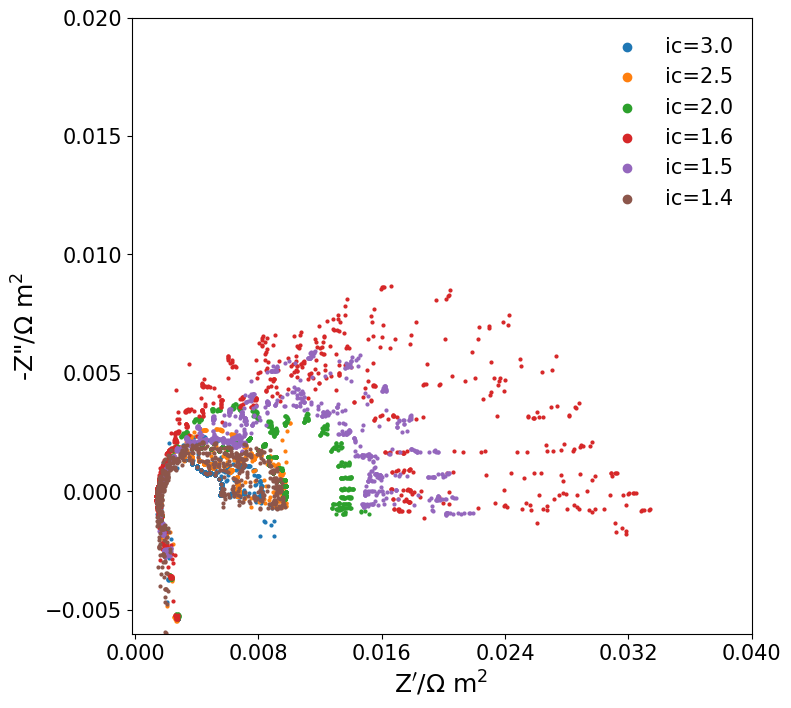

In [17]:
plt.figure(figsize=(8,8))
labels = ['ic=3.0','ic=2.5','ic=2.0','ic=1.6','ic=1.5','ic=1.4']
for s,la in zip([eis_3d0_syn, eis_2d5_syn, eis_2d0_syn,eis_1d6_syn,eis_1d5_syn, eis_1d4_syn],labels):
    plt.scatter(s[:,:31],s[:,31:],s=4,label=la)
    
plt.legend(loc='upper right',markerscale=3,frameon=False, fontsize=15)
plt.xticks(np.linspace(0,0.040,6),fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('-Z"/Ω $\mathregular{m^2}$', fontsize=18)
plt.xlabel('Z${\'}$/Ω $\mathregular{m^2}$', fontsize=18)
plt.ylim([-6e-3,2e-2])
#plt.title('Synthesis minority data ',fontsize=18)

In [18]:
x_train_se = X_train.copy()
y_train_se = y_c_train.copy()
for syn, ind in zip([eis_3d0_syn,eis_2d5_syn,eis_2d0_syn,eis_1d6_syn,eis_1d5_syn,eis_1d4_syn],[3,2.5,2,1.6,1.5,1.4]):
    x_train_se = np.append(x_train_se,syn,axis=0)
    y_train_se = np.append(y_train_se,ind*np.ones(syn.shape[0]))

In [19]:
df_x_train = pd.DataFrame(index=np.arange(0,len(y_train_se),1, dtype=int),columns=np.arange(1,63,1, dtype=int))
for i in range(len(y_train_se)):
    df_x_train.loc[i] =x_train_se[i]
df_x_train.drop_duplicates(inplace=True)
df_y_train = pd.Series(y_train_se[df_x_train.index])


In [20]:
x_train_se = df_x_train.values
y_train_se = df_y_train.values.reshape(-1, 1)
for de in [2.2]:
    delindex = NaiveENN(x_train_se, [de], y_train_se, K=5)
    if len(delindex) == 0:continue
    else:
        y_train_se = np.delete(y_train_se,delindex)
        x_train_se = np.delete(x_train_se,delindex,axis=0)

In [21]:
_data_summery.target_summery(pd.Series(df_y_train ))

,counts,proportion
2.2,94,0.248021
1.8,53,0.139842
2.0,51,0.134565
2.5,45,0.118734
1.5,45,0.118734
3.0,43,0.113456
1.6,30,0.079156
1.4,18,0.047493


In [22]:
_data_summery.target_summery(pd.Series(y_c_test))

,counts,proportion
2.2,41,0.436170
1.8,24,0.255319
2.0,6,0.063830
2.5,6,0.063830
3.0,6,0.063830
1.4,4,0.042553
1.5,4,0.042553
1.6,3,0.031915


In [23]:
print(df_x_train.shape)
print(df_y_train.shape)
print(X_test.shape)
print(y_c_test.shape)

(379, 62)
(379,)
(94, 62)
(94,)


In [ ]:
### output training and test datasets

df_x_test = pd.DataFrame(index=np.arange(0,len(y_c_test),1, dtype=int),columns=np.arange(1,63,1, dtype=int))

for j in range(len(y_c_test)):
    df_x_test.loc[j] =X_test[j]
df_x_train.to_csv('new data/x_smote_enn_train_1.csv',index=False)
df_y_train.to_csv('new data/y_smote_enn_train_1.csv',index=False,header=False)
df_x_test.to_csv('new data/x_smote_enn_test_1.csv',index=False)
pd.Series(y_c_test).to_csv('new data/y_smote_enn_test_1.csv',index=False,header=False)